# Content
1. [load package](#1-load-package)
2. [首先理解：$Softmax(XX^T)X$](#2--softmaxxxtx)
3. [$QKV$矩阵](#3-qkv矩阵)
4. [集成self-attention类](#4-集成self-attention类)
5. [多头数量的确定](#5-headnums的确定)
   
# Reference: 
* [超详细图解Self-Attention的那些事儿](https://mp.weixin.qq.com/s?__biz=MzI5MDUyMDIxNA==&mid=2247579430&idx=1&sn=3c63a42410e2107f1f91f861dc25c3cb&chksm=ec1d5adfdb6ad3c953722280aae160d9bf8a73d4cb4374de196d2a2b5bb2b53ac6b7eecbc568&mpshare=1&scene=1&srcid=05019UXsKNB17Qv7uzylnUDI&sharer_sharetime=1651341683033&sharer_shareid=d50902e5393c9beaed62a664f9b58b17#rd)
* [Attention Is All You Need(注意力模型）](https://zhuanlan.zhihu.com/p/44731789)
* [Attention 和self-attention](https://zhuanlan.zhihu.com/p/109496099)
* [超细节的BERT/Transformer知识点](https://zhuanlan.zhihu.com/p/132554155)

![](https://img2020.cnblogs.com/blog/1470684/202103/1470684-20210309221818623-1103910065.png)

# 1. load package

In [8]:
import torch
from torch import nn
from math import sqrt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style='darkgrid', font='SimHei')
if torch.cuda.is_available():
    print('Cuda is available')
    cuda0 = torch.device('cuda:0')
    X = torch.tensor([
        [1,2,1,2,1],
        [1,1,3,2,1],
        [3,1,2,1,1]
    ], dtype=torch.float64, device=cuda0)# 字向量定义
else:
    X = torch.tensor([
        [1,2,1,2,1],
        [1,1,3,2,1],
        [3,1,2,1,1]
    ], dtype=torch.float64)

Cuda is available


现在有组字向量
* 早[1,2,1,2,1]
* 上[1,1,3,2,1]
* 好[3,1,2,1,1]
* 它们构成了一个句子[早上好]
* 那么这个句子的向量则为一个矩阵，命名为$X$:
  ```[
        [1,2,1,2,1],
        [1,1,3,2,1],
        [3,1,2,1,1]
    ]
  ```

In [94]:
X

tensor([[1., 2., 1., 2., 1.],
        [1., 1., 3., 2., 1.],
        [3., 1., 2., 1., 1.]], device='cuda:0', dtype=torch.float64)

# 2. $ Softmax(XX^T)X $

## 2.1 矩阵内积$ (XX^T) $的意义
* 求矩阵内每个字向量之间的相互投影，即相关程度

In [79]:
X_dot = X@X.T
X_dot

tensor([[11., 11., 10.],
        [11., 16., 13.],
        [10., 13., 16.]], device='cuda:0', dtype=torch.float64)

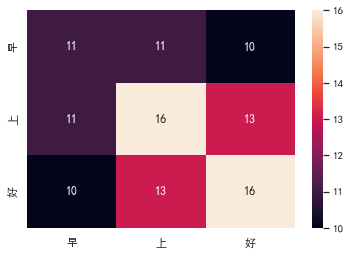

In [68]:
df_corr = pd.DataFrame(X_dot.cpu().T, columns=['早', '上', '好'], index=['早', '上', '好'])
ax = sns.heatmap(df_corr, annot=True)

## 2.2 $ Softmax() $的意义
![](https://mmbiz.qpic.cn/sz_mmbiz_jpg/gYUsOT36vfq8debSx7RJV8NahibXzTMAYfoTEVeRf6or6JibQ9KuG1kH4DblLQlxrsgKecEoxpkSUgj1d6kjpDBQ/640?wx_fmt=jpeg&wxfrom=5&wx_lazy=1&wx_co=1)
* 将进行归一化处理，转换成概率形式，使每一个字向量在其他字向量的投影的和为1

In [76]:
# torch.matmul(X, X.T)
# torch.mm(X, X.T)
softmax = nn.Softmax(dim=-1)
sft_X_dot = softmax(X @ X.T)
sft_X_dot

tensor([[0.4223, 0.4223, 0.1554],
        [0.0064, 0.9465, 0.0471],
        [0.0024, 0.0473, 0.9503]], device='cuda:0', dtype=torch.float64)

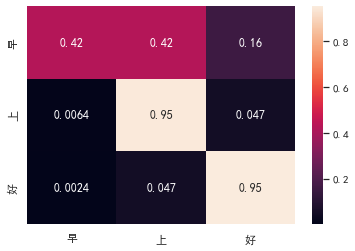

In [72]:
df_corr_weight = pd.DataFrame(sft_X_dot.cpu(), columns=['早', '上', '好'], index=['早', '上', '好'])
ax = sns.heatmap(df_corr_weight, annot=True)

## 2.3 最后一步$ Softmax(XX^T)X $的意义
![](https://mmbiz.qpic.cn/sz_mmbiz_jpg/gYUsOT36vfq8debSx7RJV8NahibXzTMAYNhw7lCUTCEpoUKNH2CEsGGqCPgNBQ1rkeYVI6cwzF4DYeX9ULXQMXA/640?wx_fmt=jpeg&wxfrom=5&wx_lazy=1&wx_co=1)
* 将“早”在每个字上的加权相关（即注意力）与原矩阵$X$的一个列向量相乘，求出一个新的行向量
* 在新的行向量中，每一个维度的数值都是由三个词向量在这一维度的数值加权求和得来的，这个新的行向量就是“早”字词向量经过注意力机制加权求和之后的表示
* $Softmax(XX^T)$为attetnion score，但是已经很难表示原本的句子，因此还需要再重新乘于$X$，得到加权后的结果。
* 单独一个$X$矩阵只能包含了word embedding内每个字的独立信息，无法包括字与字之间的信息，相互之间没什么关系。但是经过与attention score相乘后，$V$中每个token的向量（即一个单词的word embedding向量），在$N$(例如$N=5$在本例子)维的每个维度上（每一列）上，都会对其他token做出调整（关注度不同）。与$V$相乘这一步，相当于提纯，让每个单词关注该关注的部分。

In [80]:
weight_sft_X_dot = sft_X_dot@X
weight_sft_X_dot

tensor([[1.3107, 1.4223, 2.0000, 1.8446, 1.0000],
        [1.0942, 1.0064, 2.9401, 1.9529, 1.0000],
        [2.9007, 1.0024, 2.0450, 1.0497, 1.0000]], device='cuda:0',
       dtype=torch.float64)

图中右半部分的颜色深浅，其实就是我们上图中黄色向量中数值的大小，意义就是单词之间的相关度（回想之前的内容，相关度其本质是由向量的内积度量的）！

![](https://mmbiz.qpic.cn/sz_mmbiz_jpg/gYUsOT36vfq8debSx7RJV8NahibXzTMAYawvlPOUnPibj0icbBKccm4A6iaC9QiaAbWtuXGhk3XVAz4AHttjhzUq4FA/640?wx_fmt=jpeg&wxfrom=5&wx_lazy=1&wx_co=1)

# 3. $QKV$矩阵
* [Transformer中K 、Q、V的设置以及为什么不能使用同一个值](https://www.cnblogs.com/jins-note/p/14508523.html)


![](https://mmbiz.qpic.cn/sz_mmbiz_jpg/gYUsOT36vfq8debSx7RJV8NahibXzTMAYZrGVNq0AaDiamGVwhTsENJgxJCzgpAkgQhnQibDvFOHWVnFrAUNgqiccg/640?wx_fmt=jpeg&wxfrom=5&wx_lazy=1&wx_co=1)

其实，许多文章中所谓的$QKV$矩阵、查询向量之类的字眼，根本其来源都是是$X$与矩阵的乘积，**本质上都是$X$的线性变换。**
* 为什么不直接使用$X$而要对其进行线性变换？
* 当然是为了提升模型的拟合能力，矩阵$W$都是可以训练的，起到一个缓冲的效果。
* 如果你真正读懂了前文的内容，读懂了$Softmax(XX^T)$这个矩阵的意义，相信你也理解了所谓查询向量一类字眼的含义。

## 3.1 $\sqrt d_k$的意义
* $d_k$为$K$的dimension
* 假设$Softmax(QK^T)$的均值为0，方差为1，那么$d$为$Softmax(QK^T)$的方差，
  * $d$的值越大会导致$Softmax(QK^T)$的分布会趋于陡峭(分布的方差大，分布集中在绝对值大的区域)
  * 控制$Softmax(QK^T)$的分布：
    * $Softmax(QK^T)$的分布会和$d$有关。$Softmax(QK^T)$中每一个元素除以$d$后，方差又变为1。
    * 利用$\sqrt d_k$对$Softmax(QK^T)$的分布“陡峭”程度与$d$解耦，从而使得训练过程中梯度值保持稳定
* 利用$Q$输入与key-value memories做检索，找到和问题相似的memory的key计算相关性分数，然后对value embedding进行加权求和，得到一个输出向量。衍生出了self-attention里的$Q$，$K$，$V$表示，在self-attention里的把X映射到$QKV$

## 3.1 $QKV$权重矩阵$W_Q$、$W_K$和$W_V$的维度探索
![](https://img2020.cnblogs.com/blog/1470684/202103/1470684-20210309221742405-1927745420.png)
* 现有一$3*4$维矩阵$X$,即矩阵包含3个字，其word embedding的大小为5，想要重新编码为字向量长度为10的矩阵
* 即$Softmax(QK^T/\sqrt d_k)V$的输出维度是$3*10$
  * 思路：首先$Softmax(QK^T)$肯定是一个$3*3$的矩阵，因为它表示了每个字之间相互的注意力（相关程度）
  * 若要求得输出结果为$3*10$的矩阵，那么$V$的维度就一定是$3*10$
  * 而$V=XW_V$，已知$X$的维度是$3*5$，那么$W_V$的维度一定是$5*10$
* 而对于$W_Q$和$W_K$的维度，因为要保证输出的$QK^T$的维度一定是$3*3$
  * 则$Q$和$K$的维度保持一致并且一定是$3*N$
  * 以$Q$为例:
    * $Q=XW_Q$，已知$X$的维度是$3*5$，则$W_Q$的维度一定是$5*N$

In [96]:
output_size = 10
embedding_size = 5
dim_q = dim_k = 8
X

tensor([[1., 2., 1., 2., 1.],
        [1., 1., 3., 2., 1.],
        [3., 1., 2., 1., 1.]], device='cuda:0', dtype=torch.float64)

### 3.1.1 初始化各个权重矩阵

In [97]:
# 随机初始化WQ
wq = torch.randn((embedding_size, dim_q), device=cuda0, dtype=torch.float64)
# 随机初始化WK
wk = torch.randn((embedding_size, dim_k), device=cuda0, dtype=torch.float64)
# 随机初始化WV
wv = torch.randn((embedding_size, output_size), device=cuda0, dtype=torch.float64)

### 3.1.2 求出$Q$矩阵

In [98]:
Q = X@wq
Q

tensor([[-5.8332, -2.5610,  1.8061,  7.1666, -4.2463, -0.8057,  1.1351, -2.7823],
        [-1.7030, -1.5517,  0.3341,  2.5253, -4.6023,  1.4423,  1.0379, -4.8009],
        [-1.4010,  0.5444, -0.4832,  6.3650, -3.9602,  3.2184,  0.7200, -0.0427]],
       device='cuda:0', dtype=torch.float64)

### 3.1.3 求出$K$矩阵

In [99]:
K = X@wk
K

tensor([[ 2.2336,  3.1860,  2.0341,  3.5575, -0.8685, -3.7346,  3.8811,  1.3885],
        [ 5.9752,  0.4658,  1.1580,  3.7000,  1.5736, -4.0247,  1.1894,  1.6964],
        [ 2.9978,  3.7932,  2.9824, -0.4912, -3.6555, -0.5675, -0.5390,  5.0644]],
       device='cuda:0', dtype=torch.float64)

### 3.1.4 求出$V$矩阵

In [100]:
V = X@wv
V

tensor([[ 7.8362,  3.5635,  2.8100,  3.8693,  1.5980, -1.7478, -0.1589, -3.2644,
         -0.9916,  1.6436],
        [ 9.8297,  3.8295,  2.4308,  7.6969, -0.4390, -0.2967,  0.5100, -5.1272,
         -3.8701,  0.7872],
        [ 5.0569,  3.7814,  5.3357,  3.2810,  3.8979,  1.1134,  0.3318, -0.6731,
         -3.3002, -1.3283]], device='cuda:0', dtype=torch.float64)

### 3.1.5 求出$QK^T$矩阵

In [102]:
attention_score = Q@K.T
attention_score

tensor([[ 15.2200, -14.2488, -24.0578],
        [ -3.1114, -21.1249, -20.1033],
        [ 14.4212,  -3.5277,   5.3432]], device='cuda:0', dtype=torch.float64)

### 3.1.6 $QK^T/\sqrt{d_k}$：利用$d_k$对$QK^T$进行解耦，防止$QK^T$的变化过大

In [104]:
scaled_attention_score = attention_score/sqrt(dim_k)
scaled_attention_score

tensor([[ 5.3811, -5.0377, -8.5057],
        [-1.1000, -7.4688, -7.1076],
        [ 5.0987, -1.2472,  1.8891]], device='cuda:0', dtype=torch.float64)

### 3.1.7 利用Softmax()对$QK^T/\sqrt{d_k}$进行归一化处理

In [105]:
soft_scaled_att_score = softmax(scaled_attention_score)
soft_scaled_att_score

tensor([[9.9997e-01, 2.9865e-05, 9.3117e-07],
        [9.9584e-01, 1.7072e-03, 2.4499e-03],
        [9.5958e-01, 1.6830e-03, 3.8742e-02]], device='cuda:0',
       dtype=torch.float64)

### 3.1.8 将注意力矩阵$Softmax(QK^T/\sqrt{d_k})$乘上$V$，对原句进行表达

In [107]:
attention_output = soft_scaled_att_score@V
attention_output

tensor([[ 7.8363,  3.5635,  2.8100,  3.8695,  1.5980, -1.7477, -0.1589, -3.2644,
         -0.9917,  1.6436],
        [ 7.8328,  3.5645,  2.8156,  3.8744,  1.6002, -1.7383, -0.1565, -3.2612,
         -1.0022,  1.6349],
        [ 7.7319,  3.5724,  2.9072,  3.8530,  1.6837, -1.6345, -0.1387, -3.1671,
         -1.0859,  1.5270]], device='cuda:0', dtype=torch.float64)

## 3.2 当batch_size>1时

### 3.2.1 定义一个例子

In [4]:
X2 = torch.tensor([[[1,2,1,2,1], # 早
                    [1,1,3,2,1], # 上
                    [3,1,2,1,1]], # 好
                    
                    [[3,1,2,1,1], # 好
                    [1,1,3,2,1], # 早
                    [1,2,1,2,1]] # 上
                ], dtype=torch.float64, device=cuda0)
X2, X2.size()

(tensor([[[1., 2., 1., 2., 1.],
          [1., 1., 3., 2., 1.],
          [3., 1., 2., 1., 1.]],
 
         [[3., 1., 2., 1., 1.],
          [1., 1., 3., 2., 1.],
          [1., 2., 1., 2., 1.]]], device='cuda:0', dtype=torch.float64),
 torch.Size([2, 3, 5]))

In [112]:
batch_size = X2.size()[0]
batch_size

2

### 3.2.2 先实现$Softmax(XX^T)X$

In [118]:
X2_dot = torch.bmm(X2, X2.permute(0, 2, 1))
X2_dot

tensor([[[11., 11., 10.],
         [11., 16., 13.],
         [10., 13., 16.]],

        [[16., 13., 10.],
         [13., 16., 11.],
         [10., 11., 11.]]], device='cuda:0', dtype=torch.float64)

In [120]:
soft_X2_dot = softmax(X2_dot)
soft_X2_dot

tensor([[[0.4223, 0.0064, 0.0024],
         [0.4223, 0.9465, 0.0473],
         [0.1554, 0.0471, 0.9503]],

        [[0.9503, 0.0471, 0.1554],
         [0.0473, 0.9465, 0.4223],
         [0.0024, 0.0064, 0.4223]]], device='cuda:0', dtype=torch.float64)

In [125]:
torch.bmm(soft_X2_dot, X2)

tensor([[[0.4358, 0.8534, 0.4462, 0.8597, 0.4311],
         [1.5108, 1.8385, 3.3564, 2.7849, 1.4161],
         [3.0535, 1.3082, 2.1974, 1.3553, 1.1528]],

        [[3.0535, 1.3082, 2.1974, 1.3553, 1.1528],
         [1.5108, 1.8385, 3.3564, 2.7849, 1.4161],
         [0.4358, 0.8534, 0.4462, 0.8597, 0.4311]]], device='cuda:0',
       dtype=torch.float64)

### 3.2.3 实现$Softmax(QK^T/\sqrt{d_k})V$

In [126]:
embedding_size = 5
dim_q = dim_k = 8
output_size = 10

#### 3.2.3.1 定义qkv权重

In [130]:
# q = nn.Linear(embedding_size, dim_q)
# k = nn.Linear(embedding_size, dim_k)
# v = nn.Linear(embedding_size, output_size)
wq = torch.randn(batch_size, embedding_size, dim_q, device=cuda0, dtype=torch.float64)
wk = torch.randn(batch_size, embedding_size, dim_k, device=cuda0, dtype=torch.float64)
wv = torch.randn(batch_size, embedding_size, output_size, device=cuda0, dtype=torch.float64)


In [132]:
Q = torch.bmm(X2, wq)
Q

tensor([[[ 1.5582, -0.8717, -1.3706, -1.0544,  0.4997,  1.3938, -3.4247,
           5.0492],
         [ 1.2169, -3.1864, -2.7058, -1.2611,  1.9660,  3.3174, -3.5892,
           7.2948],
         [ 3.3495, -2.1440, -6.9993, -7.4153, -1.1284,  4.5366, -7.4462,
           8.1977]],

        [[-2.5640, -4.1961,  5.0915, -4.3541,  2.0638,  0.5317, -3.3642,
          -1.2488],
         [-4.0804, -4.5291,  4.7965, -0.4264,  5.1302, -0.7123, -1.3305,
          -1.7631],
         [-0.5793, -5.0655,  3.4297, -3.4159,  3.6012, -1.2186,  0.1353,
          -2.5812]]], device='cuda:0', dtype=torch.float64)

In [133]:
K = torch.bmm(X2, wk)
K

tensor([[[-1.4164, -2.9752,  7.1337,  1.8657, -3.0496, -0.0352,  1.0243,
           0.7829],
         [-5.7465, -4.5874,  8.2959,  5.6329, -1.0198,  0.8279,  0.2871,
           0.2422],
         [-4.1353, -4.7825,  8.3578,  4.5925, -3.8728,  5.0690, -0.2854,
           1.1925]],

        [[ 2.4248, 11.3674, -2.6641,  3.5242,  7.8670,  5.0724, -5.4677,
           0.1940],
         [ 0.0773,  8.6462, -3.3254, -1.5883,  3.3939,  4.4412, -7.7996,
          -1.4249],
         [ 2.6913,  5.3212, -2.8643, -1.2792,  5.0154, -1.4874, -4.7116,
          -2.5206]]], device='cuda:0', dtype=torch.float64)

In [139]:
V = torch.bmm(X2, wv)
V

tensor([[[-4.8002, -0.6814, -1.6538, -3.0207, -2.9105, -2.0037, -5.2438,
          -3.4670, -1.9490, -1.4147],
         [-3.0350, -1.4567, -0.8261, -5.5171, -4.2596, -1.5180, -3.4168,
          -4.7778,  1.9638, -1.9664],
         [-6.9332,  0.0449, -1.4575, -6.8872, -4.6898,  2.3824, -0.2478,
          -1.3238, -3.3458, -6.0011]],

        [[-6.0053,  3.0739, -3.5484,  3.1885, -0.3823,  2.5164,  4.9871,
          -4.8868, -5.7102, -2.2606],
         [-5.7088,  2.0548, -3.5776, -2.1744,  2.3161,  0.2995,  1.5970,
          -2.1827, -4.8814, -4.2858],
         [-6.9242,  1.6778, -3.4086,  0.9004, -0.4242,  1.3941,  4.1422,
          -2.0995, -7.1041,  0.1113]]], device='cuda:0', dtype=torch.float64)

In [134]:
QK_T = torch.bmm(Q, K.permute(0, 2, 1))
QK_T

tensor([[[ -12.4868,  -21.3811,   -6.4442],
         [ -17.9769,  -20.4481,    0.7261],
         [ -60.0598, -104.4932,  -56.8849]],

        [[ -45.7394,   -9.1095,   -9.6846],
         [ -31.9809,  -27.6112,  -10.7733],
         [ -59.2530,  -40.3890,   -8.2256]]], device='cuda:0',
       dtype=torch.float64)

In [135]:
scaled_QK_T = QK_T/sqrt(dim_k)
scaled_QK_T

tensor([[[ -4.4147,  -7.5594,  -2.2784],
         [ -6.3558,  -7.2295,   0.2567],
         [-21.2343, -36.9439, -20.1119]],

        [[-16.1713,  -3.2207,  -3.4240],
         [-11.3069,  -9.7620,  -3.8089],
         [-20.9491, -14.2797,  -2.9082]]], device='cuda:0',
       dtype=torch.float64)

In [136]:
soft_scaled_QK_T = softmax(scaled_QK_T)
soft_scaled_QK_T

tensor([[[8.7447e-01, 4.1828e-01, 7.3434e-02],
         [1.2553e-01, 5.8172e-01, 9.2657e-01],
         [4.3360e-08, 7.2428e-14, 1.3210e-09]],

        [[7.6571e-03, 9.9854e-01, 2.9801e-01],
         [9.9228e-01, 1.4404e-03, 2.0280e-01],
         [6.4431e-05, 1.5722e-05, 4.9919e-01]]], device='cuda:0',
       dtype=torch.float64)

In [140]:
batch_attention_output = torch.bmm(soft_scaled_QK_T, V)
batch_attention_output

tensor([[[-5.9762e+00, -1.2019e+00, -1.8987e+00, -5.4549e+00, -4.6712e+00,
          -2.2122e+00, -6.0329e+00, -5.1274e+00, -1.1286e+00, -2.5003e+00],
         [-8.7922e+00, -8.9135e-01, -2.0387e+00, -9.9701e+00, -7.1887e+00,
           1.0728e+00, -2.8755e+00, -4.4411e+00, -2.2023e+00, -6.8819e+00],
         [-2.1729e-07, -2.9486e-08, -7.3633e-08, -1.4007e-07, -1.3240e-07,
          -8.3735e-08, -2.2770e-07, -1.5208e-07, -8.8928e-08, -6.9270e-08]],

        [[-7.8100e+00,  2.5753e+00, -4.6153e+00, -1.8785e+00,  2.1834e+00,
           7.3379e-01,  2.8673e+00, -2.8426e+00, -7.0351e+00, -4.2637e+00],
         [-7.3714e+00,  3.3933e+00, -4.2175e+00,  3.3433e+00, -4.6205e-01,
           2.7801e+00,  5.7910e+00, -5.2780e+00, -7.1139e+00, -2.2268e+00],
         [-3.4570e+00,  8.3776e-01, -1.7018e+00,  4.4964e-01, -2.1173e-01,
           6.9607e-01,  2.0681e+00, -1.0484e+00, -3.5467e+00,  5.5369e-02]]],
       device='cuda:0', dtype=torch.float64)

# 4. 集成self-attention类

## 4.1 单头self-attention

In [154]:
class Self_Attention(nn.Module):
    def __init__(self, embedding_size, dim_k, output_size):
        super(Self_Attention, self).__init__()
        # input (batch_size, seq_len, embedding_size)
        # q (batch_size, embedding_size, dim_k)
        # k (batch_size, embedding_size, dim_k)
        # v (batch_size, embedding_size, output_size)
        # self.batch_size = batch_size
        self.embedding_size = embedding_size
        self.dim_q = self.dim_k = dim_k
        self.dim_v = output_size
        self.output_size = output_size
        self.norm_factor = 1/sqrt(self.dim_k)

        self.q = nn.Linear(self.embedding_size, self.dim_q)
        self.k = nn.Linear(self.embedding_size, self.dim_k)
        self.v = nn.Linear(self.embedding_size, self.dim_v)

    def forward(self, x):
        Q = self.q(x) # dim: batch_size * seq_len * dim_q
        K = self.k(x) # dim: batch_size * seq_len * dim_k
        V = self.v(x) # dim: batch_size * seq_len * output_size(dim_v)

        attention_score = torch.bmm(Q, K.permute(0, 2, 1)) * self.norm_factor # dim: batch_size * seq_len * seq_len
        soft_attention_score = nn.Softmax(dim=-1)(attention_score) # dim: batch_size * seq_len * seq_len
        output = torch.bmm(soft_attention_score, V) # dim: batch_size * seq_len * output_size(dim_v)

        return output

In [150]:
batch_size = 2
seq_len = 3
embedding_size = 4
x = torch.randn(batch_size, seq_len, embedding_size) # dim: batch_size=2, seq_len=3, embedding_size=4
x, x.size()

(tensor([[[ 0.2042,  0.0748,  1.2078, -0.9053],
          [ 0.0406,  1.0886, -1.9610,  0.4739],
          [-0.1113,  1.6448,  1.4125,  0.5346]],
 
         [[ 0.6377,  0.0266, -0.5305,  1.2798],
          [ 0.0883,  0.0724,  0.2831, -0.3107],
          [-0.2889,  0.6488,  0.2794,  0.3465]]]),
 torch.Size([2, 3, 4]))

In [153]:
self_attention = Self_Attention(embedding_size=embedding_size, dim_k=10, output_size=5)
res = self_attention(x)
res, res.size()

(tensor([[[ 0.3356, -0.1771,  0.3725,  0.6132, -0.2158],
          [ 0.3355, -0.1658,  0.3703,  0.5375, -0.2064],
          [ 0.3772, -0.2019,  0.4047,  0.7072, -0.1733]],
 
         [[ 0.2221, -0.4991,  0.2550,  0.4026, -0.4349],
          [ 0.2605, -0.4543,  0.2559,  0.4056, -0.3882],
          [ 0.2621, -0.4526,  0.2555,  0.4072, -0.3866]]],
        grad_fn=<BmmBackward0>),
 torch.Size([2, 3, 5]))

## 4.2 多头self-attention
![](https://pic2.zhimg.com/80/v2-ed923dba9f3c3f32decd2b8a6283da41_720w.jpg)

In [160]:
head_nums = 2

In [5]:
X2, X2.shape

(tensor([[[1., 2., 1., 2., 1.],
          [1., 1., 3., 2., 1.],
          [3., 1., 2., 1., 1.]],
 
         [[3., 1., 2., 1., 1.],
          [1., 1., 3., 2., 1.],
          [1., 2., 1., 2., 1.]]], device='cuda:0', dtype=torch.float64),
 torch.Size([2, 3, 5]))

In [192]:
Q_mh = torch.bmm(X2, wq).reshape(-1, # batch_size
                                 X2.shape[0], # seq_len
                                 X2.shape[1], # embedding_size
                                 dim_q//head_nums # segmented by head_nums
                                )
Q_mh, Q_mh.size()

(tensor([[[[ 1.5582, -0.8717, -1.3706, -1.0544],
           [ 0.4997,  1.3938, -3.4247,  5.0492],
           [ 1.2169, -3.1864, -2.7058, -1.2611]],
 
          [[ 1.9660,  3.3174, -3.5892,  7.2948],
           [ 3.3495, -2.1440, -6.9993, -7.4153],
           [-1.1284,  4.5366, -7.4462,  8.1977]]],
 
 
         [[[-2.5640, -4.1961,  5.0915, -4.3541],
           [ 2.0638,  0.5317, -3.3642, -1.2488],
           [-4.0804, -4.5291,  4.7965, -0.4264]],
 
          [[ 5.1302, -0.7123, -1.3305, -1.7631],
           [-0.5793, -5.0655,  3.4297, -3.4159],
           [ 3.6012, -1.2186,  0.1353, -2.5812]]]], device='cuda:0',
        dtype=torch.float64),
 torch.Size([2, 2, 3, 4]))

In [194]:
K_mh = torch.bmm(X2, wk).reshape(-1, X2.shape[0], X2.shape[1], dim_k//head_nums)
K_mh, K_mh.size()

(tensor([[[[-1.4164, -2.9752,  7.1337,  1.8657],
           [-3.0496, -0.0352,  1.0243,  0.7829],
           [-5.7465, -4.5874,  8.2959,  5.6329]],
 
          [[-1.0198,  0.8279,  0.2871,  0.2422],
           [-4.1353, -4.7825,  8.3578,  4.5925],
           [-3.8728,  5.0690, -0.2854,  1.1925]]],
 
 
         [[[ 2.4248, 11.3674, -2.6641,  3.5242],
           [ 7.8670,  5.0724, -5.4677,  0.1940],
           [ 0.0773,  8.6462, -3.3254, -1.5883]],
 
          [[ 3.3939,  4.4412, -7.7996, -1.4249],
           [ 2.6913,  5.3212, -2.8643, -1.2792],
           [ 5.0154, -1.4874, -4.7116, -2.5206]]]], device='cuda:0',
        dtype=torch.float64),
 torch.Size([2, 2, 3, 4]))

In [195]:
V_mh = torch.bmm(X2, wv).reshape(-1, X2.shape[0], X2.shape[1], output_size//head_nums)
V_mh, V_mh.size()

(tensor([[[[-4.8002, -0.6814, -1.6538, -3.0207, -2.9105],
           [-2.0037, -5.2438, -3.4670, -1.9490, -1.4147],
           [-3.0350, -1.4567, -0.8261, -5.5171, -4.2596]],
 
          [[-1.5180, -3.4168, -4.7778,  1.9638, -1.9664],
           [-6.9332,  0.0449, -1.4575, -6.8872, -4.6898],
           [ 2.3824, -0.2478, -1.3238, -3.3458, -6.0011]]],
 
 
         [[[-6.0053,  3.0739, -3.5484,  3.1885, -0.3823],
           [ 2.5164,  4.9871, -4.8868, -5.7102, -2.2606],
           [-5.7088,  2.0548, -3.5776, -2.1744,  2.3161]],
 
          [[ 0.2995,  1.5970, -2.1827, -4.8814, -4.2858],
           [-6.9242,  1.6778, -3.4086,  0.9004, -0.4242],
           [ 1.3941,  4.1422, -2.0995, -7.1041,  0.1113]]]], device='cuda:0',
        dtype=torch.float64),
 torch.Size([2, 2, 3, 5]))

In [207]:
# Q_mh · K_mh.T
atten_score_mh = nn.Softmax(dim=-1)(Q_mh@K_mh.permute(0, 1, 3, 2)/sqrt(dim_k))
atten_score_mh, atten_score_mh.size()

(tensor([[[[1.7325e-01, 8.2309e-01, 3.6642e-03],
           [1.2543e-03, 9.4497e-01, 5.3775e-02],
           [8.9611e-02, 9.0514e-01, 5.2456e-03]],
 
          [[2.0897e-03, 8.8452e-07, 9.9791e-01],
           [9.9953e-01, 4.1441e-14, 4.6726e-04],
           [5.0206e-06, 3.8078e-13, 9.9999e-01]]],
 
 
         [[[2.6388e-06, 2.3406e-04, 9.9976e-01],
           [5.0330e-04, 9.9835e-01, 1.1421e-03],
           [6.1493e-04, 8.1297e-05, 9.9930e-01]],
 
          [[2.4960e-02, 5.0111e-04, 9.7454e-01],
           [2.1488e-07, 1.7090e-05, 9.9998e-01],
           [3.1182e-03, 9.6729e-04, 9.9591e-01]]]], device='cuda:0',
        dtype=torch.float64),
 torch.Size([2, 2, 3, 3]))

In [208]:
atten_score_mhV_mh = (atten_score_mh@V_mh)
atten_score_mhV_mh, atten_score_mhV_mh.size()

(tensor([[[[-2.4920e+00, -4.4395e+00, -3.1432e+00, -2.1477e+00, -1.6843e+00],
           [-2.0627e+00, -5.0345e+00, -3.3227e+00, -2.1422e+00, -1.5696e+00],
           [-2.2597e+00, -4.8151e+00, -3.2906e+00, -2.0637e+00, -1.5637e+00]],
 
          [[ 2.3742e+00, -2.5439e-01, -1.3310e+00, -3.3347e+00, -5.9927e+00],
           [-1.5162e+00, -3.4153e+00, -4.7762e+00,  1.9613e+00, -1.9683e+00],
           [ 2.3823e+00, -2.4779e-01, -1.3238e+00, -3.3457e+00, -6.0011e+00]]],
 
 
         [[[-5.7069e+00,  2.0555e+00, -3.5779e+00, -2.1752e+00,  2.3151e+00],
           [ 2.5027e+00,  4.9828e+00, -4.8846e+00, -5.7017e+00, -2.2545e+00],
           [-5.7083e+00,  2.0557e+00, -3.5777e+00, -2.1714e+00,  2.3141e+00]],
 
          [[ 1.3626e+00,  4.0775e+00, -2.1022e+00, -7.0446e+00,  1.3222e-03],
           [ 1.3939e+00,  4.1422e+00, -2.0995e+00, -7.1040e+00,  1.1133e-01],
           [ 1.3826e+00,  4.1319e+00, -2.1010e+00, -7.0894e+00,  9.7115e-02]]]],
        device='cuda:0', dtype=torch.float64),
 t

In [209]:
# concat multi-head
res_mh = atten_score_mhV_mh.reshape(X2.shape[0], X2.shape[1], -1)
res_mh, res_mh.size()

(tensor([[[-2.4920e+00, -4.4395e+00, -3.1432e+00, -2.1477e+00, -1.6843e+00,
           -2.0627e+00, -5.0345e+00, -3.3227e+00, -2.1422e+00, -1.5696e+00],
          [-2.2597e+00, -4.8151e+00, -3.2906e+00, -2.0637e+00, -1.5637e+00,
            2.3742e+00, -2.5439e-01, -1.3310e+00, -3.3347e+00, -5.9927e+00],
          [-1.5162e+00, -3.4153e+00, -4.7762e+00,  1.9613e+00, -1.9683e+00,
            2.3823e+00, -2.4779e-01, -1.3238e+00, -3.3457e+00, -6.0011e+00]],
 
         [[-5.7069e+00,  2.0555e+00, -3.5779e+00, -2.1752e+00,  2.3151e+00,
            2.5027e+00,  4.9828e+00, -4.8846e+00, -5.7017e+00, -2.2545e+00],
          [-5.7083e+00,  2.0557e+00, -3.5777e+00, -2.1714e+00,  2.3141e+00,
            1.3626e+00,  4.0775e+00, -2.1022e+00, -7.0446e+00,  1.3222e-03],
          [ 1.3939e+00,  4.1422e+00, -2.0995e+00, -7.1040e+00,  1.1133e-01,
            1.3826e+00,  4.1319e+00, -2.1010e+00, -7.0894e+00,  9.7115e-02]]],
        device='cuda:0', dtype=torch.float64),
 torch.Size([2, 3, 10]))

In [9]:
class Self_Attention_multi_head(nn.Module):
    # input: batch_size, seq_len, embedding_size
    # q: batch_size, embedding_size, dim_q
    # k: batch_size, embedding_size, dim_k
    # v: batch_size, embedding_size, dim_v
    def __init__(self, embedding_size, dim_k, output_size, head_nums):
        super(Self_Attention_multi_head, self).__init__()
        assert dim_k % head_nums == 0
        assert output_size % head_nums == 0
        self.embedding_size = embedding_size
        self.dim_q = self.dim_k = dim_k
        self.dim_v = output_size
        self.q = nn.Linear(self.embedding_size, self.dim_q)
        self.k = nn.Linear(self.embedding_size, self.dim_k)
        self.v = nn.Linear(self.embedding_size, self.dim_v)
        self.norm_factor = 1/sqrt(dim_k)
        self.head_nums = head_nums

    def forward(self, x):
        Q = self.q(x).reshape(-1, x.shape[0], x.shape[1], self.dim_q//self.head_nums) 
        # Q dim: batch_size, multi-segment(head_nums), seq_len, embedding_size/head_nums
        K = self.k(x).reshape(-1, x.shape[0], x.shape[1], self.dim_k//self.head_nums)
        # K dim: batch_size, multi-segment(head_nums), seq_len, embedding_size/head_nums
        V = self.v(x).reshape(-1, x.shape[0], x.shape[1], self.dim_v//self.head_nums)
        # V dim: batch_size, multi-segment(head_nums), seq_len, outputs_size/head_nums

        QK = Q @ K.permute(0, 1, 3, 2)
        # QK dim: batch_size, multi-segment(head_nums), seq_len, seq_len
        scaled_QK = QK * self.norm_factor
        atten_mh = nn.Softmax(dim=-1)(scaled_QK)
        # atten_mh dim: batch_size, multi-segment(head_nums), seq_len, seq_len
        atten_mhV = atten_mh @ V
        # atten_mhV dim: batch_size, multi-segment(head_nums), seq_len, output_size/head_nums

        output = atten_mhV.reshape(x.shape[0], x.shape[1], -1)
        # concat multi-segment
        # output dim: batch_size, seq_len, output_size
        return output

In [212]:
batch_size = 2
seq_len = 3
embedding_size = 4
x = torch.randn(batch_size, seq_len, embedding_size) # dim: batch_size=2, seq_len=3, embedding_size=4
x, x.size()

(tensor([[[ 0.9022, -0.9151,  0.2304,  0.5386],
          [ 1.2929, -0.2612,  1.4492, -1.6717],
          [ 0.9719,  0.4376,  0.2973, -0.4038]],
 
         [[-1.6375,  0.1130, -1.7010,  1.8347],
          [ 0.8031, -1.2434,  0.1808,  1.2782],
          [-0.2180, -1.1914,  0.6073, -1.2531]]]),
 torch.Size([2, 3, 4]))

In [213]:
dim_k = 6
output_size = 10
head_nums = 2
self_attention_mh = Self_Attention_multi_head(embedding_size=embedding_size, 
                                              dim_k=dim_k, 
                                              output_size=output_size,
                                              head_nums=head_nums)
res = self_attention_mh(x)
res, res.size()

(tensor([[[ 0.1972, -0.3130,  0.0528,  0.0773,  0.3722,  0.2201, -0.2592,
            0.0494,  0.0707,  0.3857],
          [ 0.2272, -0.4015, -0.0439,  0.1180,  0.3787,  0.1338, -0.5360,
            0.0356,  0.1468,  0.2021],
          [ 0.1159, -0.5426,  0.0500,  0.1513,  0.2313,  0.0940, -0.5458,
            0.0652,  0.1568,  0.2582]],
 
         [[ 0.0424,  1.4424,  0.5992, -0.5465,  0.3334,  0.0136,  1.3545,
            0.6691, -0.5385,  0.3220],
          [ 0.0192,  0.7246,  0.4727, -0.5457, -0.4344,  0.5148, -0.1021,
           -0.2016, -0.1437,  0.4408],
          [ 0.5322, -0.0837, -0.2489, -0.0924,  0.4787,  0.5260, -0.0898,
           -0.2341, -0.1079,  0.4670]]], grad_fn=<ViewBackward>),
 torch.Size([2, 3, 10]))

# 5. head_nums的确定

In [6]:
batch_size = 2
seq_len = 3
embedding_size = 100
x2 = torch.randn(batch_size, seq_len, embedding_size)

In [12]:
head_nums = 4
dim_k = 64
output_size = 100
self_attention_mh = Self_Attention_multi_head(embedding_size=embedding_size,
                                              dim_k=dim_k,
                                              output_size=output_size,
                                              head_nums=head_nums)

In [15]:
res = self_attention_mh(x2)
res.size()

torch.Size([2, 3, 100])